In [1]:
import requests
from bs4 import BeautifulSoup, SoupStrainer
import re
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np
import seaborn as sns
from pprint import pprint

In [2]:
base_url = 'https://english.mubasher.info/markets/EGX/stocks/'

### Getting Companies Listed in EGX from Trading View:

In [3]:
# resp = requests.get('https://www.tradingview.com/symbols/EGX-EGX30/components/')
resp = requests.get('https://www.tradingview.com/markets/stocks-egypt/market-movers-large-cap/')
soup = BeautifulSoup(resp.text)
symbols = []
for i, tag in enumerate(soup.findAll('a', attrs={'class': re.compile('^apply-common-tooltip')})): 
    if(i%2==0 and tag.string != 'EGS923M1C017'):
        symbols.append(tag.string)

In [4]:
div_tags = SoupStrainer(attrs={'class': re.compile('^stock-overview')})

In [5]:
soup = BeautifulSoup(resp.text, 'lxml', parse_only=div_tags)
print(soup.prettify())

<!DOCTYPE html>



### Defining Filtering Criteria

In [6]:
def has_book_value(tag):
    return tag.string and re.compile("^Book Value").search(tag.string.get_text())

def has_market_cap(tag):
    return tag.string and re.compile("Market Cap").search(tag.string.get_text())

def has_total_shares(tag):
    return tag.string and re.compile("Current Total Shares").search(tag.string.get_text())
def has_eps(tag):
    return tag.string and re.compile("EPS").search(tag.string.get_text())

#### Defining DataFrame Columns List

In [7]:
symbols_list = []
update_dates = []
ratios = []
names = []
EPS = []
prices = []
book_values =[]

### Scraping The Page OF Each Company

In [8]:
for symbol in symbols:
    resp = requests.get(base_url+symbol)
    div_tags = SoupStrainer(attrs={'class': re.compile('^stock-overview')})
    soup = BeautifulSoup(resp.text, 'lxml', parse_only=div_tags)
    book_value_span = soup.find_all(has_book_value)[0]
    
    eps_span = soup.find_all(has_eps)[0]
    quarter = book_value_span.find_next_sibling('span').find('span', class_='market-summary__date').string.get_text()
    
    book_value = float(book_value_span.find_next_sibling('span').find('span', class_=re.compile('^number')).string.replace(',',''))
    
    currency = book_value_span.find_next_sibling('span').find('span', string='Egyptian Pound')

                                                              
    eps = float(eps_span.find_next_sibling('span').find('span', class_=re.compile('^number')).string.get_text())
    
    h1_tags = SoupStrainer('h1')
    soup = BeautifulSoup(resp.text, 'lxml', parse_only=h1_tags)
    name = soup.find('h1').string
 

    
    price_tags = SoupStrainer('div', attrs={'class': re.compile('^market-summary__last-price')})
    soup = BeautifulSoup(resp.text, 'lxml', parse_only=price_tags)
    last_price = float(soup.find().string)
    if book_value != 0 and currency != None:
        p2B = round(last_price/book_value,2)
        if p2B < 1 and p2B > 0:
            symbols_list.append(symbol)
            update_dates.append(quarter.replace('\n', ' ').strip("Based on: "))
            ratios.append(p2B)
            names.append(name)
            EPS.append(eps)
            prices.append(last_price)
            book_values.append(book_value)
    

### Loading The Data to Pandas Data Frame:

In [9]:
data = {'Company': names, 'Symbol': symbols_list,'EPS': EPS, 'Price':prices,'Book Value': book_values, 'P/B': ratios, 'Date of Book Value Update': update_dates}

df = pd.DataFrame(data)
df['year'] = df['Date of Book Value Update'].str[-4:]
df['Quarter'] = df['Date of Book Value Update'].str.split().str[0]
df['Company'] = df['Company'].str.split().str[:-1].str.join(' ')
quarter_order = ['First', 'Second', 'Third', 'Fourth']
df['Quarter'] = pd.Categorical(df['Quarter'], categories=quarter_order, ordered=True)
df['Diff_PCT %'] = round(((df['Book Value'] - df ['Price'] )/ df['Price']) * 100,2)
df = df.sort_values(by=['Diff_PCT %', 'year','Quarter'], ascending=False)
df = df[['Company', 'Symbol', 'P/B','Price','Book Value','Date of Book Value Update', 'Diff_PCT %']]
df = df.reset_index(drop=True)
df



,Company,Symbol,P/B,Price,Book Value,Date of Book Value Update,Diff_PCT %
0,Faisal Islamic Bank of Egypt,FAIT,0.21,33.01,154.90,First Quarter 2024,369.25
1,Pioneers Properties for Urban Development,PRDC,0.43,3.25,7.63,First Quarter 2024,134.77
2,Orascom Investment Holding,OIH,0.48,0.39,0.81,Second Quarter 2024,107.69
3,Lecico - Egypt,LCSW,0.61,22.14,36.35,Second Quarter 2024,64.18
4,GB Corp,GBCO,0.69,14.30,20.73,First Quarter 2024,44.97
5,Export Development Bank of Egypt,EXPA,0.69,15.44,22.23,Second Quarter 2024,43.98
6,Suez Canal Bank ASE,CANA,0.78,15.21,19.55,Second Quarter 2024,28.53
7,Misr Hotels,MHOT,0.78,21.31,27.36,Third Quarter 2024,28.39
8,Al Baraka Bank - Egypt,SAUD,0.82,12.17,14.81,Second Quarter 2024,21.69
9,CI Capital Holding For Financial Investments,CICH,0.83,5.28,6.36,Second Quarter 2024,20.45


### Plotting Book Value Vs Price

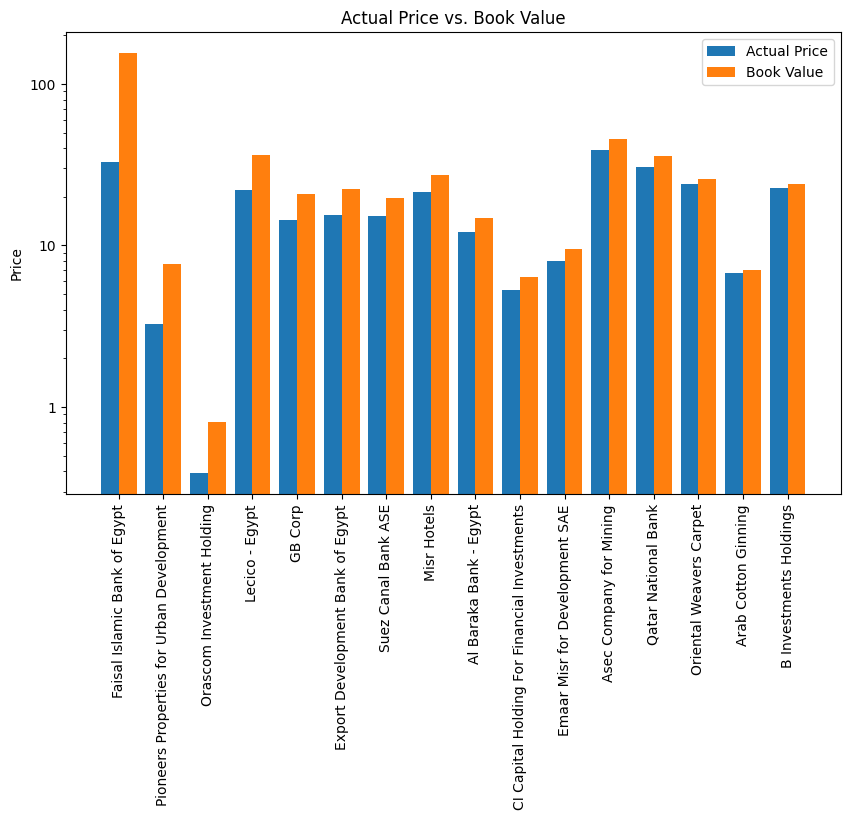

In [10]:
fig, ax = plt.subplots(figsize=(10,6))

x = np.arange(len(df))
ax.set_xticks(x)
ax.set_xticklabels(df['Company'], rotation='vertical')

ax.bar(x-0.2, df['Price'], width=0.4, label='Actual Price')
ax.bar(x+0.2, df['Book Value'], width=0.4, label='Book Value')

ax.set_ylabel('Price')

ax.set_title('Actual Price vs. Book Value')

plt.legend()
plt.yscale('log')

formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.yaxis.set_major_formatter(formatter)



plt.show()
